In [1]:
from tensorflow.python import keras
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

keras.__version__

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'2.1.3-tf'

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)  # one-hot
test_labels = to_categorical(test_labels)

In [3]:
def data_generator(x, y, batch_size=32):
    batches = int(len(x)/batch_size)
    while 1:
        for i in range(batches):
            yield x[i*batch_size:(i+1)*batch_size], y[i*batch_size:(i+1)*batch_size]

In [4]:
img_size=(28, 28, 1)
class NeuralNet:
    def __init__(self, use_batch_norm, activation='relu'):
        self.use_batch_norm = use_batch_norm
        self.build_model(activation=activation)
    def add_dense_layer(self, units, activation='relu'):
        if self.use_batch_norm:
            self.model.add(layers.Dense(units, use_bias=False))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Dense(units, activation=activation))
    def add_conv2d_layer(self, filters, kernel_size, activation='relu', **kwargs):
        if self.use_batch_norm:
            self.model.add(layers.Conv2D(filters, kernel_size, use_bias=False, **kwargs))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Conv2D(filters, kernel_size, activation=activation, **kwargs))
    def build_model(self, activation):
        self.model = models.Sequential()
        self.add_conv2d_layer(32, (3, 3), activation=activation, input_shape=img_size)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.Flatten())
        self.add_dense_layer(64, activation=activation)
        self.add_dense_layer(10, activation='softmax')
    def train(self, learning_rate=0.001, epoches=40, batch_size=32, steps_per_epoch=30):
        self.model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
        history = self.model.fit_generator(generator=data_generator(train_images, train_labels, batch_size=batch_size),
                                      steps_per_epoch = steps_per_epoch,
                                      epochs = epoches,
                                      validation_data=data_generator(test_images, test_labels, batch_size=batch_size),
                                      validation_steps=len(test_images)/batch_size)
        return history.history

In [6]:
def plot_training_accuracies(*args, **kwargs):
    """
    Displays a plot of the accuracies calculated during training to demonstrate
    how many iterations it took for the model(s) to converge.
    
    :param args: One or more NeuralNet objects
        You can supply any number of NeuralNet objects as unnamed arguments 
        and this will display their training accuracies. Be sure to call `train` 
        the NeuralNets before calling this function.
    :param kwargs: 
        You can supply any named parameters here, but `steps_per_epoch` is the only
        one we look for. It should match the `steps_per_epoch` value you passed
        to the `train` function.
    """
    fig, ax = plt.subplots()

    steps_per_epoch = kwargs['steps_per_epoch']
    
    for history in args:
        ax.plot(range(0,len(history['acc'])*steps_per_epoch,steps_per_epoch),
                history['acc'], label="acc-" + history['name'])
        ax.plot(range(0,len(history['val_acc'])*steps_per_epoch,steps_per_epoch),
                history['val_acc'], label="val_acc-"+history['name'])
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy During Training')
    ax.legend(loc=4)
    #ax.set_ylim([0,1])
    #plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()
    
def train_and_test(learning_rate=0.001, activation="relu", epochs=40, steps_per_epoch=30):
    nn = NeuralNet(use_batch_norm=False, activation=activation)
    bn = NeuralNet(use_batch_norm=True, activation=activation)
    history_nn = nn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_bn = bn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_nn['name'] = "Without batch normalization"
    history_bn['name'] = "With batch normalization"
    plot_training_accuracies(history_nn, history_bn, steps_per_epoch=steps_per_epoch)

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 56s 30ms/step - loss: 0.1503 - acc: 0.9544 - val_loss: 0.0512 - val_acc: 0.9825

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 60s 32ms/step - loss: 0.0488 - acc: 0.9853 - val_loss: 0.0367 - val_acc: 0.9880

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 54s 29ms/step - loss: 0.0329 - acc: 0.9902 - val_loss: 0.0320 - val_acc: 0.9900

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 330s 176ms/step - loss: 0.2703 - acc: 0.9617 - val_loss: 0.0705 - val_acc: 0.9876

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 323s 172ms/step - loss: 0.0910 - acc: 0.9840 - val_loss: 0.0421 - val_acc: 0.9897

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 328s 175m

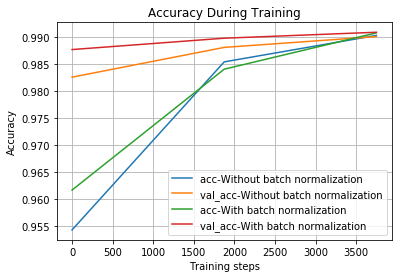

In [7]:
train_and_test(learning_rate=0.001, activation='relu', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 56s 30ms/step - loss: 0.6191 - acc: 0.7993 - val_loss: 0.1369 - val_acc: 0.9598

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 55s 29ms/step - loss: 0.1046 - acc: 0.9691 - val_loss: 0.0842 - val_acc: 0.9757

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 55s 29ms/step - loss: 0.0682 - acc: 0.9799 - val_loss: 0.0765 - val_acc: 0.9771

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 342s 182ms/step - loss: 0.3274 - acc: 0.9502 - val_loss: 0.3501 - val_acc: 0.9095

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 337s 180ms/step - loss: 0.1341 - acc: 0.9732 - val_loss: 0.2142 - val_acc: 0.9414

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 333s 178m

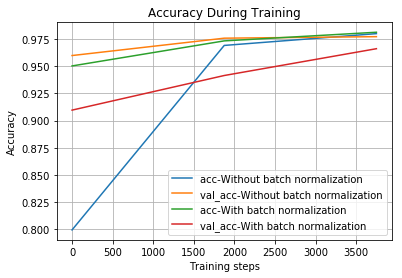

In [8]:
train_and_test(learning_rate=0.001, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 55s 29ms/step - loss: 0.1707 - acc: 0.9487 - val_loss: 0.1423 - val_acc: 0.9608

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 53s 28ms/step - loss: 0.1103 - acc: 0.9697 - val_loss: 0.0939 - val_acc: 0.9728

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 52s 28ms/step - loss: 0.1054 - acc: 0.9718 - val_loss: 0.1032 - val_acc: 0.9773

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 312s 166ms/step - loss: 0.1408 - acc: 0.9655 - val_loss: 0.0474 - val_acc: 0.9856

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 328s 175ms/step - loss: 0.0582 - acc: 0.9837 - val_loss: 0.0492 - val_acc: 0.9844

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 319s 170m

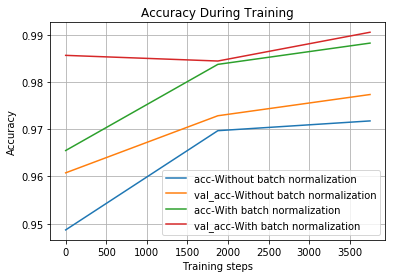

In [9]:
train_and_test(learning_rate=0.01, activation='relu', epochs=3, steps_per_epoch=1875)

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 58s 31ms/step - loss: 2.3155 - acc: 0.0998 - val_loss: 2.3034 - val_acc: 0.1136

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 56s 30ms/step - loss: 2.3142 - acc: 0.1000 - val_loss: 2.3034 - val_acc: 0.1136

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 56s 30ms/step - loss: 2.3142 - acc: 0.1001 - val_loss: 2.3033 - val_acc: 0.1134

Epoch 1/3
1875/1875 [==============================]1875/1875 [==============================] - 320s 170ms/step - loss: 0.1765 - acc: 0.9562 - val_loss: 0.6226 - val_acc: 0.7953

Epoch 2/3
1875/1875 [==============================]1875/1875 [==============================] - 319s 170ms/step - loss: 0.0699 - acc: 0.9797 - val_loss: 0.0835 - val_acc: 0.9759

Epoch 3/3
1875/1875 [==============================]1875/1875 [==============================] - 319s 170m

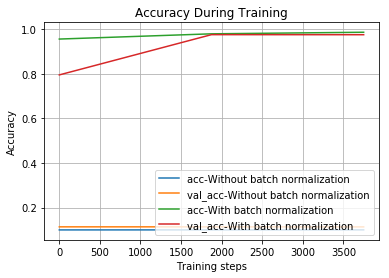

In [10]:
train_and_test(learning_rate=0.01, activation='sigmoid', epochs=3, steps_per_epoch=1875)